In [1]:
# progress checking

# imports
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import numpy as np
import os

[NeMo W 2022-05-16 15:58:27 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [11]:
seed=100
# test = "Man darf sich nicht von anderen entmutigen lassen."
# test_id = "2edfc39c95ef247c6e39c929d122f4cc"
data_path="/github/datasets/openslr-95-german-neutral-tts/thorsten-de/wavs/"

# 4 train samples

# test = "Das Hotel konnte keine Rechnung ausstellen."
# test_id = "b6dade90f15f80ba638036432235769c"

# test = "Das Kind hat neununddrei\u00dfig Komma acht Grad Fieber."
# test_id = "cdedc8011ff030d1b1159d25ef977c7b"

# test = "Und schon ebbt der Besucherandrang wieder ab!"
# test_id = "f9cbc359b4cfc161e79a9124a59f657a"

# test = "Sie kann es jedenfalls nicht leiden."
# test_id = "efeee077d3fcaede1dde2201a549c4d8"

# 4 test samples
# test = "Einer geht noch."
# test_id = "e1509ecf93c001510e0c0c985d221973"

# test = "Dieser Pilz ist zwar nicht giftig, aber ungenie\u00dfbar."
# test_id = "b1e9265fcc34a4d3691eb2c6921198a2"

# test = "Denn wir wollen nat\u00fcrlich nicht, dass durch die Einf\u00fchrung von Mindestlohn die Menschen, die heute eine Arbeit haben, vielleicht dann arbeitslos werden."
# test_id = "625fee42255c5524910b1461ea67472f"

# test = "Das ist ja auch nur grob \u00fcber den Daumen gepeilt."
# test_id = "661fcdabe38439e548aa44ef6d27aa36"


# 2 val samples
# test = "Auch mutige Menschen haben Angst."
# test_id = "0e14b2f2352b602483b5e7d107a07040"

test = "Dabei ist zu beachten, dass Babys sogar bis zu drei\u00dfig Kilohertz h\u00f6ren k\u00f6nnen."
test_id = "c784aa96ffceae0259cccc05a7b34bd4"

In [4]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size()) # debug
    #     audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=0.8, denoise=True)
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram


# A: Fastpitch trained from scratch & HiFiGAN fine-tuned on german neutral TTS (openSLR)

## R1 Train fastpitch from scratch and eval on HiFiGAN pre-trained on English

In [7]:
hfg_ngc="tts_hifigan"
fastpitchckptsdir="/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/"

In [8]:
# load vocoder and spectrogram generator models
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
fastpitchmodelpaths = [os.path.abspath(os.path.join(fastpitchckptsdir, f)) for f in os.listdir(fastpitchckptsdir)]
spec_gen_models = {path: FastPitchModel.load_from_checkpoint(checkpoint_path=path).eval().cuda() for path in fastpitchmodelpaths}


[NeMo I 2022-05-16 16:09:08 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-05-16 16:09:08 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-05-16 16:09:08 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-16 16:09:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-05-16 16:09:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-05-16 16:09:09 features:259] PADDING: 0
[NeMo I 2022-05-16 16:09:09 features:276] STFT using torch


[NeMo W 2022-05-16 16:09:09 features:233] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-16 16:09:09 features:259] PADDING: 0
[NeMo I 2022-05-16 16:09:09 features:276] STFT using torch
[NeMo I 2022-05-16 16:09:10 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-05-16 16:09:12 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-16 16:09:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-16 16:09:26 features:259] PADDING: 1
[NeMo I 2022-05-16 16:09:26 features:276] STFT using torch
[NeMo I 2022-05-16 16:09:27 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-16 16:09:47 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-16 16:09:47 features:259] PADDING: 1
[NeMo I 2022-05-16 16:09:47 features:276] STFT using torch
[NeMo I 2022-05-16 16:09:48 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-16 16:10:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-16 16:10:09 features:259] PADDING: 1
[NeMo I 2022-05-16 16:10:09 features:276] STFT using torch


In [9]:
# list of old R1 checkpoints
!ls /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/

'FastPitch--v_loss=0.6817-epoch=214.ckpt'
'FastPitch--v_loss=0.6848-epoch=294-last.ckpt'
'FastPitch--v_loss=0.6877-epoch=999-last.ckpt'


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/FastPitch--v_loss=0.6817-epoch=214.ckpt
torch.Size([1, 80, 532])


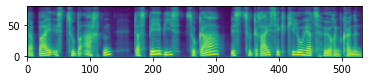

original audio


predicted audio


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/FastPitch--v_loss=0.6877-epoch=999-last.ckpt
torch.Size([1, 80, 542])


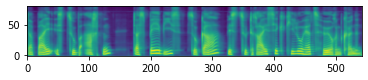

original audio


predicted audio


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/FastPitch--v_loss=0.6848-epoch=294-last.ckpt
torch.Size([1, 80, 532])


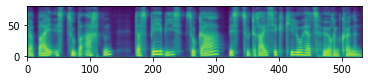

original audio


predicted audio


In [12]:
%matplotlib inline

# ckptpath = "/akshita/R1priorckpts/FastPitch--v_loss=0.6877-epoch=999-last.ckpt"
for ckptpath in spec_gen_models.keys():
    print("predicting from fastpitch ckptpath "+ckptpath)
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_models[ckptpath], vocoder_model, test)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(filename=data_path+test_id+".wav", rate=22050))
    print("predicted audio")
    ipd.display(ipd.Audio(audio, rate=22050))

### R2: fine-tune HiFiGAN on German, evluate with R1 Fastpitch (model A)

#### R21: HiFiGAN fine-tuned on predicted FastPitch mels at 999 epochs

In [14]:
# list available R21 models
!ls /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts

'HifiGan21--val_loss=0.3506-epoch=189.ckpt'
'HifiGan21--val_loss=0.3510-epoch=169.ckpt'
'HifiGan21--val_loss=0.3511-epoch=199-last.ckpt'
'HifiGan21--val_loss=0.3511-epoch=199.ckpt'
'HifiGan21--val_loss=0.3514-epoch=159.ckpt'
'HifiGan21--val_loss=0.3516-epoch=179.ckpt'
 HifiGan21.nemo


In [13]:
fastpitch_path = "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/FastPitch--v_loss=0.6877-epoch=999-last.ckpt"
hifiganmodelpaths = ["/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3514-epoch=159.ckpt","/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3506-epoch=189.ckpt", "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3511-epoch=199-last.ckpt"]


In [15]:
# load spectrogram generator and vocoder models

r2_vocoder_models = {path: (HifiGanModel.restore_from(path).eval().cuda() if ".nemo" in path else HifiGanModel.load_from_checkpoint(checkpoint_path=path).eval().cuda()) for path in hifiganmodelpaths}
r2_spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_path).eval().cuda()


[NeMo W 2022-05-16 16:11:30 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/synmels1/hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-05-16 16:11:30 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.dat

[NeMo I 2022-05-16 16:11:30 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:30 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:30 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:11:30 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:30 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:30 features:278] STFT using exact pad


[NeMo W 2022-05-16 16:11:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/synmels1/hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-05-16 16:11:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.dat

[NeMo I 2022-05-16 16:11:33 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:33 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:33 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:11:33 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:33 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:33 features:278] STFT using exact pad


[NeMo W 2022-05-16 16:11:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/synmels1/hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-05-16 16:11:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.dat

[NeMo I 2022-05-16 16:11:37 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:37 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:37 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:11:37 features:259] PADDING: 0
[NeMo I 2022-05-16 16:11:37 features:276] STFT using torch
[NeMo I 2022-05-16 16:11:37 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:11:38 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-16 16:11:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-16 16:11:53 features:259] PADDING: 1
[NeMo I 2022-05-16 16:11:53 features:276] STFT using torch


predicting from hifigan ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3514-epoch=159.ckpt
torch.Size([1, 80, 542])


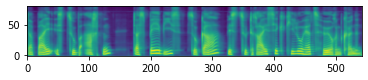

original audio


predicted audio


predicting from hifigan ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3506-epoch=189.ckpt
torch.Size([1, 80, 542])


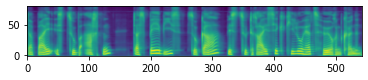

original audio


predicted audio


predicting from hifigan ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R21priorckpts/HifiGan21--val_loss=0.3511-epoch=199-last.ckpt
torch.Size([1, 80, 542])


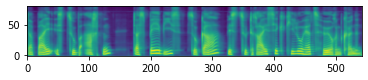

original audio


predicted audio


In [16]:
%matplotlib inline

for ckptpath in r2_vocoder_models.keys():
    print("predicting from hifigan ckptpath "+ckptpath)
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(r2_spec_gen_model, r2_vocoder_models[ckptpath], test)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
    print("predicted audio")
    ipd.display(ipd.Audio(audio, rate=22050))

#### R22: HiFiGAN fine-tuned on target Mels

In [18]:
# list available R22 models
!ls /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R22priorckpts

'HifiGan22--val_loss=2.6570-epoch=9.ckpt'
'HifiGan22--val_loss=2.6841-epoch=19.ckpt'
'HifiGan22--val_loss=2.6856-epoch=39.ckpt'
'HifiGan22--val_loss=2.6886-epoch=29.ckpt'
'HifiGan22--val_loss=2.6945-epoch=59-last.ckpt'
'HifiGan22--val_loss=2.6945-epoch=59.ckpt'
 incorrect


In [17]:
fastpitch_path = "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R1priorckpts/FastPitch--v_loss=0.6877-epoch=999-last.ckpt"
hifiganmodelpaths = ["/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R22priorckpts/HifiGan22--val_loss=2.6570-epoch=9.ckpt"]

In [19]:
# load spectrogram generator and vocoder models

r22_spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_path).eval().cuda()
r22_vocoder_models = {path: (HifiGanModel.restore_from(path).eval().cuda() if ".nemo" in path else HifiGanModel.load_from_checkpoint(checkpoint_path=path).eval().cuda()) for path in hifiganmodelpaths}
                  

[NeMo I 2022-05-16 16:12:21 tokenize_and_classify:87] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-05-16 16:12:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 132.5526885986328
      pitch_std: 37.61381912231445
    dataloader_params:
      drop_last: false

[NeMo I 2022-05-16 16:12:41 features:259] PADDING: 1
[NeMo I 2022-05-16 16:12:41 features:276] STFT using torch


[NeMo W 2022-05-16 16:12:43 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/orig_synmels/hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-05-16 16:12:43 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch

[NeMo I 2022-05-16 16:12:43 features:259] PADDING: 0
[NeMo I 2022-05-16 16:12:43 features:276] STFT using torch
[NeMo I 2022-05-16 16:12:43 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:12:43 features:259] PADDING: 0
[NeMo I 2022-05-16 16:12:43 features:276] STFT using torch
[NeMo I 2022-05-16 16:12:43 features:278] STFT using exact pad


predicting from hifigan ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R22priorckpts/HifiGan22--val_loss=2.6570-epoch=9.ckpt
torch.Size([1, 80, 542])


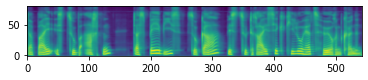

original audio


predicted audio


In [20]:
%matplotlib inline

for ckptpath in r22_vocoder_models.keys():
    print("predicting from hifigan ckptpath "+ckptpath)
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(r22_spec_gen_model, r22_vocoder_models[ckptpath], test)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
    print("predicted audio")
    ipd.display(ipd.Audio(audio, rate=22050))

# B: Fastpitch & HiFiGAN fine-tuned on german neutral TTS (openSLR)

## R3: Fastpitch_en finetuned on german dataset
## R4: HifiGan_en finetuned on Fastpitch predicted mels for german dataset

In [21]:
# list available R3 models
!ls /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R4priorckpts/

/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts:
'FastPitch--v_loss=0.6679-epoch=149.ckpt'
'FastPitch--v_loss=0.6692-epoch=99.ckpt'
'FastPitch--v_loss=0.6705-epoch=224.ckpt'
'FastPitch--v_loss=0.6717-epoch=174.ckpt'
'FastPitch--v_loss=0.6720-epoch=74-last.ckpt'
'FastPitch--v_loss=0.6727-epoch=124.ckpt'
'FastPitch--v_loss=0.6770-epoch=199-last.ckpt'
'FastPitch--v_loss=0.6770-epoch=199.ckpt'
'FastPitch--v_loss=0.6807-epoch=424-last.ckpt'
'FastPitch--v_loss=0.6901-epoch=799-last.ckpt'
 FastPitch.nemo

/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R4priorckpts/:
'HifiGan4--val_loss=0.3598-epoch=199-last.ckpt'
'HifiGan4--val_loss=0.3598-epoch=199.ckpt'
'HifiGan4--val_loss=0.3599-epoch=179.ckpt'
'HifiGan4--val_loss=0.3609-epoch=149.ckpt'
'HifiGan4--val_loss=0.3609-epoch=159.ckpt'
'HifiGan4--val_loss=0.3612-epoch=89.ckpt'
 HifiGan4.nemo
 incorrect


In [22]:
fastpitchmodelpaths = ["/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6720-epoch=74-last.ckpt", "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6679-epoch=149.ckpt", "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6901-epoch=799-last.ckpt"]
# hfg_ngc="tts_hifigan"
# R22 - finetuned on target mels OR R4
hfg_ngc = "/github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R4priorckpts/HifiGan4--val_loss=0.3598-epoch=199-last.ckpt"


In [23]:
# load vocoder and spectrogram generator models

r34_spec_gen_models = {path: FastPitchModel.load_from_checkpoint(checkpoint_path=path).eval().cuda() for path in fastpitchmodelpaths}


[NeMo I 2022-05-16 16:13:43 tokenize_and_classify:93] Creating ClassifyFst grammars.


[NeMo W 2022-05-16 16:14:08 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-16 16:14:08 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null

[NeMo I 2022-05-16 16:14:08 features:259] PADDING: 1
[NeMo I 2022-05-16 16:14:08 features:276] STFT using torch
[NeMo I 2022-05-16 16:14:10 tokenize_and_classify:93] Creating ClassifyFst grammars.


[NeMo W 2022-05-16 16:14:37 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-16 16:14:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null

[NeMo I 2022-05-16 16:14:37 features:259] PADDING: 1
[NeMo I 2022-05-16 16:14:37 features:276] STFT using torch
[NeMo I 2022-05-16 16:14:38 tokenize_and_classify:93] Creating ClassifyFst grammars.


[NeMo W 2022-05-16 16:15:07 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-16 16:15:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/thorsten-de/train_manifest.json
      sample_rate: 22050
      sup_data_path: /Data/openslr-95-german-neutral-tts/thorsten-de/sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null

[NeMo I 2022-05-16 16:15:07 features:259] PADDING: 1
[NeMo I 2022-05-16 16:15:07 features:276] STFT using torch


In [24]:
# vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
r34_vocoder_model = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_ngc).eval().cuda()


[NeMo W 2022-05-16 16:15:09 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /Data/openslr-95-german-neutral-tts/synmels/hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 0
    
[NeMo W 2022-05-16 16:15:09 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.data

[NeMo I 2022-05-16 16:15:09 features:259] PADDING: 0
[NeMo I 2022-05-16 16:15:09 features:276] STFT using torch
[NeMo I 2022-05-16 16:15:09 features:278] STFT using exact pad
[NeMo I 2022-05-16 16:15:09 features:259] PADDING: 0
[NeMo I 2022-05-16 16:15:09 features:276] STFT using torch
[NeMo I 2022-05-16 16:15:09 features:278] STFT using exact pad


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6720-epoch=74-last.ckpt


[NeMo W 2022-05-16 16:15:10 tts_tokenizers:351] Text: [dabei ist zu beachten, DAE1S BEY1BIY0Z sogar BIH1S zu dreißig KIH1LAH0HHEH2RTS HHAO1RAH0N konnen.] contains unknown char/phoneme: [ß]. Original text: [Dabei ist zu beachten, dass Babys sogar bis zu dreißig Kilohertz horen konnen.]. Symbol will be skipped.


torch.Size([1, 80, 499])


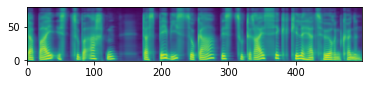

original audio


predicted audio


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6679-epoch=149.ckpt


[NeMo W 2022-05-16 16:15:11 tts_tokenizers:351] Text: [dabei ist zu beachten, DAE1S BEY1BIY0Z sogar BIH1S zu dreißig KIH1LAH0HHEH2RTS HHAO1RAH0N konnen.] contains unknown char/phoneme: [ß]. Original text: [Dabei ist zu beachten, dass Babys sogar bis zu dreißig Kilohertz horen konnen.]. Symbol will be skipped.


torch.Size([1, 80, 503])


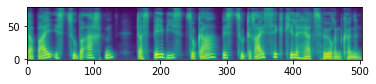

original audio


predicted audio


predicting from fastpitch ckptpath /github/ngc_workspace_backup/ngc_ws_tts_aagermanfastpitch/R3priorckpts/FastPitch--v_loss=0.6901-epoch=799-last.ckpt


[NeMo W 2022-05-16 16:15:11 tts_tokenizers:351] Text: [dabei ist zu beachten, DAE1S BEY1BIY0Z sogar BIH1S zu dreißig KIH1LAH0HHEH2RTS HHAO1RAH0N konnen.] contains unknown char/phoneme: [ß]. Original text: [Dabei ist zu beachten, dass Babys sogar bis zu dreißig Kilohertz horen konnen.]. Symbol will be skipped.


torch.Size([1, 80, 529])


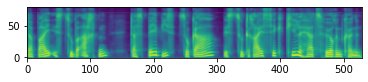

original audio


predicted audio


In [25]:
%matplotlib inline

# ckptpath = "/akshita/R1priorckpts/FastPitch--v_loss=0.6877-epoch=999-last.ckpt"
for ckptpath in r34_spec_gen_models.keys():
    print("predicting from fastpitch ckptpath "+ckptpath)
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(r34_spec_gen_models[ckptpath], r34_vocoder_model, test)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(filename=data_path+test_id+".wav", rate=22050))
    print("predicted audio")
    ipd.display(ipd.Audio(audio, rate=22050))